In [2]:
# Cell for importing
import os
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    roc_curve,
    auc,
)

os.makedirs("models", exist_ok=True)
os.makedirs("figures", exist_ok=True)


In [3]:
df = pd.read_csv("Data/bicycle_thefts_cleaned.csv")
df.head()
# Loading our dataset


,EVENT_UNIQUE_ID,PRIMARY_OFFENCE,OCC_DATE,OCC_YEAR,OCC_MONTH,OCC_DOW,OCC_DAY,OCC_DOY,OCC_HOUR,REPORT_DATE,...,LOCATION_TYPE,PREMISES_TYPE,BIKE_MODEL,BIKE_TYPE,BIKE_SPEED,BIKE_COLOUR,BIKE_COST,NEIGHBOURHOOD_158,NEIGHBOURHOOD_140,TARGET_RETURNED
0,-1.744753,-3.464648,-1.160795,-1.877802,-1.106880,0.498184,1.197090,2.055402,0.874757,-2.168121,...,-0.199290,-0.860047,-1.054008,0.122455,0.533432,1.577958,0.195206,-0.595592,1.207926,0
1,-1.744654,-1.118874,-2.169620,-1.568322,-0.542159,1.485695,-1.697099,-2.561089,0.721260,-2.168121,...,0.854001,0.117736,0.412030,0.967870,-1.014201,-0.917044,-0.179012,0.490120,0.568544,1
2,-1.744851,0.300937,-2.169620,-1.568322,-0.542159,1.485695,-1.697099,-2.561089,-0.967206,-2.168121,...,-1.450073,-1.348938,0.836116,-0.722960,-0.317766,-0.917044,-0.179012,0.803306,0.911070,0
3,-1.611084,0.300937,-2.169620,-1.568322,-0.542159,1.485695,-1.697099,-2.561089,-0.199721,-2.064536,...,-1.450073,-1.348938,0.635774,-0.300253,-0.395148,-0.637432,0.019947,-0.595592,1.207926,0
4,-1.744456,0.300937,1.315179,-1.877802,1.434363,-0.983083,1.660160,0.936642,-2.041683,-2.064536,...,-1.450073,-1.348938,-1.510058,-0.722960,0.533432,-0.917044,-0.147828,-0.240648,-0.185013,0


In [5]:
# Target column from our cleaned CSV
target_col = "TARGET_RETURNED"

# Use ALL columns except the target as features
feature_cols = [col for col in df.columns if col != target_col]

# Create X (features) and y (target)
X = df[feature_cols]
y = df[target_col]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.3,
    random_state=42,
    stratify=y
)

X_train.shape, X_test.shape

# This is defining our feature columns and the target


((27631, 25), (11842, 25))

In [9]:
# This is a helper function to evaluate a trained model and return its metrics + ROC info
def evaluate_model(name, model, X_test, y_test):
    """Compute metrics + ROC info for a fitted model."""
    y_pred = model.predict(X_test)

    # probabilities for ROC/AUC
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:, 1]
    else:
        if hasattr(model, "decision_function"):
            scores = model.decision_function(X_test)
            y_proba = (scores - scores.min()) / (scores.max() - scores.min())
        else:
            y_proba = y_pred

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)

    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)

    cm = confusion_matrix(y_test, y_pred)

    print(f"\n=== {name} ===")
    print(f"Accuracy : {acc:.3f}")
    print(f"Precision: {prec:.3f}")
    print(f"Recall   : {rec:.3f}")
    print(f"F1-score : {f1:.3f}")
    print(f"AUC      : {roc_auc:.3f}")
    print("Confusion matrix:\n", cm)

    return {
        "name": name,
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1": f1,
        "auc": roc_auc,
        "cm": cm,
        "fpr": fpr,
        "tpr": tpr,
    }

In [10]:
# Logistic Regression
# Train Logistic Regression on the training data and evaluate it on the test set
log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(X_train, y_train)
log_metrics = evaluate_model("Logistic Regression", log_reg, X_test, y_test)

# Decision Tree
# Train Decision Tree on the training data and evaluate it on the test set
tree = DecisionTreeClassifier(random_state=42)
tree.fit(X_train, y_train)
tree_metrics = evaluate_model("Decision Tree", tree, X_test, y_test)



=== Logistic Regression ===
Accuracy : 0.990
Precision: 0.000
Recall   : 0.000
F1-score : 0.000
AUC      : 0.679
Confusion matrix:
 [[11723     0]
 [  119     0]]

=== Decision Tree ===
Accuracy : 0.980
Precision: 0.120
Recall   : 0.151
F1-score : 0.134
AUC      : 0.570
Confusion matrix:
 [[11591   132]
 [  101    18]]


In [11]:
# This is taking the results and creating a summary table comparing both models scores
results = pd.DataFrame(
    [
        {
            "Model": "Logistic Regression",
            "Accuracy": log_metrics["accuracy"],
            "Precision": log_metrics["precision"],
            "Recall": log_metrics["recall"],
            "F1": log_metrics["f1"],
            "AUC": log_metrics["auc"],
        },
        {
            "Model": "Decision Tree",
            "Accuracy": tree_metrics["accuracy"],
            "Precision": tree_metrics["precision"],
            "Recall": tree_metrics["recall"],
            "F1": tree_metrics["f1"],
            "AUC": tree_metrics["auc"],
        },
    ]
)
results

# Picks the best model based on the higher F1-score
if log_metrics["f1"] >= tree_metrics["f1"]:
    best_model_name = "Logistic Regression"
    best_model = log_reg
    best_metrics = log_metrics
else:
    best_model_name = "Decision Tree"
    best_model = tree
    best_metrics = tree_metrics

best_model_name, best_metrics


('Decision Tree',
 {'name': 'Decision Tree',
  'accuracy': 0.9803242695490627,
  'precision': 0.12,
  'recall': 0.15126050420168066,
  'f1': 0.13382899628252787,
  'auc': np.float64(0.5700002938990147),
  'cm': array([[11591,   132],
         [  101,    18]]),
  'fpr': array([0.        , 0.01125992, 1.        ]),
  'tpr': array([0.       , 0.1512605, 1.       ])})

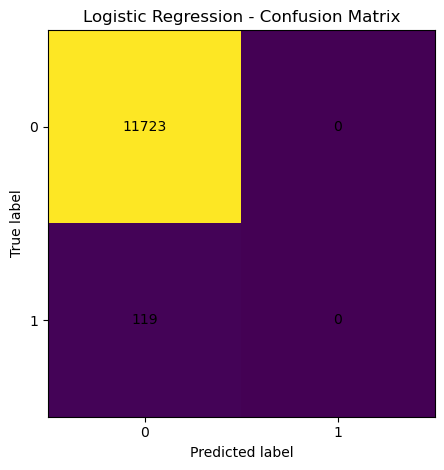

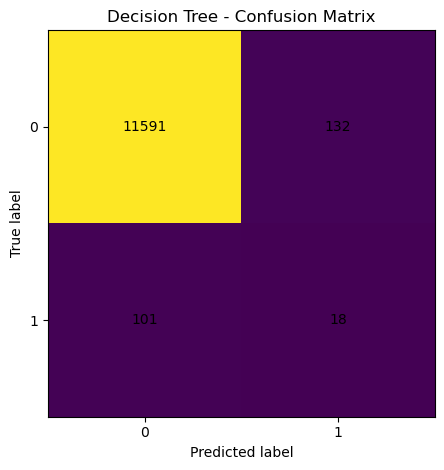

In [12]:
# Plot and saves a confusion matrix image for a given model
def plot_confusion_matrix(cm, title, filename):
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation="nearest")
    ax.set_title(title)
    ax.set_xlabel("Predicted label")
    ax.set_ylabel("True label")
    ax.set_xticks([0, 1])
    ax.set_yticks([0, 1])
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, cm[i, j], ha="center", va="center")
    fig.tight_layout()
    plt.savefig(os.path.join("figures", filename))
    plt.show()

# Plots confusion matrices for both models and saves them to the figures folder
plot_confusion_matrix(log_metrics["cm"], "Logistic Regression - Confusion Matrix", "cm_logistic.png")
plot_confusion_matrix(tree_metrics["cm"], "Decision Tree - Confusion Matrix", "cm_tree.png")


In [13]:
# Saves the best performing model to disk for person 4s API
model_path = os.path.join("models", "final_model.pkl")

with open(model_path, "wb") as f:
    pickle.dump(best_model, f)

print(f"Saved best model ({best_model_name}) to {model_path}")


Saved best model (Decision Tree) to models/final_model.pkl


In [14]:
feature_cols
# This is for the list of features used to train the model


['EVENT_UNIQUE_ID',
 'PRIMARY_OFFENCE',
 'OCC_DATE',
 'OCC_YEAR',
 'OCC_MONTH',
 'OCC_DOW',
 'OCC_DAY',
 'OCC_DOY',
 'OCC_HOUR',
 'REPORT_DATE',
 'REPORT_YEAR',
 'REPORT_MONTH',
 'REPORT_DOW',
 'REPORT_DAY',
 'REPORT_DOY',
 'REPORT_HOUR',
 'LOCATION_TYPE',
 'PREMISES_TYPE',
 'BIKE_MODEL',
 'BIKE_TYPE',
 'BIKE_SPEED',
 'BIKE_COLOUR',
 'BIKE_COST',
 'NEIGHBOURHOOD_158',
 'NEIGHBOURHOOD_140']